## Basic Pre-Processing

### Import necessarry Modules

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### Read .csv

In [2]:
df = pd.read_csv("Flowster_Topic_Attributes.csv")
# Check for null values in data
df[df.isnull().any(axis=1)]

,id,Topic Title,Category,Tags,Author,Commenters,Leading Comment,Other Comments,Likes,Views
245,245,Israel Cohen’s Success Story,Misc Topics,['Member Introductions'],Trent-Admin,[],NaN,[],0,0


Drop any row with null value-

In [3]:
df.drop(df[df.isnull().any(axis=1)].index, inplace=True)

### Convert to Lowercase

In [4]:
df['Leading Comment'] = df['Leading Comment'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['Other Comments'] = df['Other Comments'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df[['Leading Comment', 'Other Comments']].head()

,Leading Comment,Other Comments
0,have questions about sourcing products? this i...,[]
1,hi! we are new to the forum and are going thro...,['yes you will need the paid version. options ...
2,as i am working in amazon as a seller from las...,[]
3,"does anyone have a va they recommend, have use...",['@mcdavid most don’t want to share any stella...
4,can you sell branded products on amazon uk or ...,['you can sell on amazon uk as well. it could ...


### Remove Punctuation

In [5]:
df['Leading Comment'] = df['Leading Comment'].str.replace('[^\w\s]','')
df['Other Comments'] = df['Other Comments'].str.replace('[^\w\s]','')
df['Tags'] = df['Tags'].str.replace('[^\w\s]','')
df[['Leading Comment', 'Other Comments', 'Tags']].head()

,Leading Comment,Other Comments,Tags
0,have questions about sourcing products this is...,,
1,hi we are new to the forum and are going throu...,yes you will need the paid version options for...,
2,as i am working in amazon as a seller from las...,,Purchasing
3,does anyone have a va they recommend have used...,mcdavid most dont want to share any stellar va...,
4,can you sell branded products on amazon uk or ...,you can sell on amazon uk as well it could act...,Sourcing Brand Name Products


### Remove Stopwords

In [6]:
stop = stopwords.words('english')
df['Leading Comment'] = df['Leading Comment'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['Other Comments'] = df['Other Comments'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df[['Leading Comment', 'Other Comments']].head()

,Leading Comment,Other Comments
0,questions sourcing products category use pleas...,
1,hi new forum going product sourcing profession...,yes need paid version options extraction tools...
2,working amazon seller last 6 years want tips s...,
3,anyone va recommend used currently using requi...,mcdavid dont want share stellar va currently u...
4,sell branded products amazon uk must amazon com,sell amazon uk well could actually big selling...


### Exploring the Data

#### Analysing the Tag Frequencies

<function matplotlib.pyplot.show(*args, **kw)>

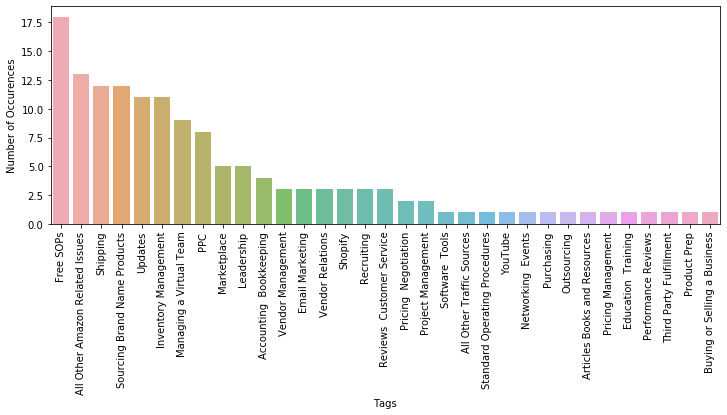

In [7]:
cnt_tags = df['Tags'].value_counts()[1:]
plt.figure(figsize=(12,4))
sns.barplot(cnt_tags.index, cnt_tags.values, alpha=0.8)
plt.ylabel('Number of Occurences')
plt.xlabel('Tags')
plt.xticks(rotation=90)
plt.show

This gives us an idea about which Tags are being extensively used and which ones are rarely used in the comments.

#### Analysing the Categorical Freuqencies

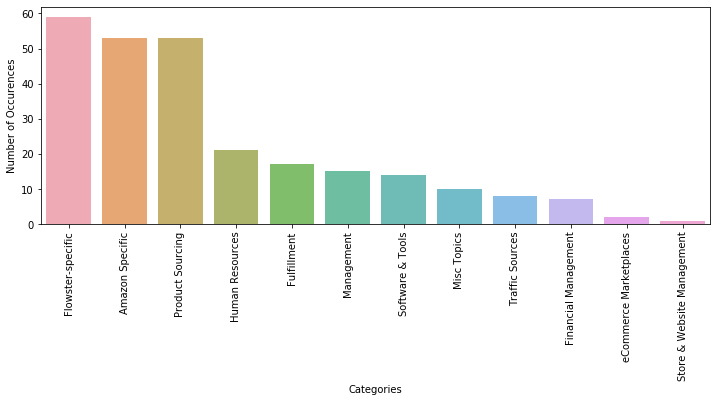

In [8]:
cnt_categ = df['Category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_categ.index, cnt_categ.values, alpha=0.8)
plt.ylabel('Number of Occurences')
plt.xlabel('Categories')
plt.xticks(rotation=90)
plt.show()

This gives us an abstract idea about which Category has more comments than others.

In [9]:
df.shape

(260, 10)

In [10]:
df.index = range(260)
df['Leading Comment'].apply(lambda x: len(x.split(' '))).sum()

9836

In [11]:
df['Other Comments'].apply(lambda x: len(x.split(' '))).sum()

15956

We have 260 samples in total.
After removing stop words from the Leading Comments, we have 9836 words in total.
After removing stop words from the Other Comments, we have 15959 words in total.

### Tokenization

Here, for every sample we combine the Categoory, Tags, Leading Comment and Other Comments to get a set of words used in that Sample. These tokens will help in further analysis and modelling.

In [12]:
df['Tokens'] = df['Category'] + ' ' + df['Tags'] + ' ' + df['Leading Comment'] + ' ' + df['Other Comments']

In [13]:
df['Tokens'] = df['Tokens'].str.replace('  ', ' ')
df['Tokens'].head()

0    Product Sourcing questions sourcing products c...
1    Product Sourcing hi new forum going product so...
2    Product Sourcing Purchasing working amazon sel...
3    Product Sourcing anyone va recommend used curr...
4    Product Sourcing Sourcing Brand Name Products ...
Name: Tokens, dtype: object

In [14]:
df.head()

,id,Topic Title,Category,Tags,Author,Commenters,Leading Comment,Other Comments,Likes,Views,Tokens
0,0,About the Product Sourcing Category,Product Sourcing,,Trent-Admin,[],questions sourcing products category use pleas...,,0,0,Product Sourcing questions sourcing products c...
1,1,Price Checker 2 - Competitor storefront extrac...,Product Sourcing,,Mitch,['MoniqueAndKerry'],hi new forum going product sourcing profession...,yes need paid version options extraction tools...,0,25,Product Sourcing hi new forum going product so...
2,2,Top 10 Tips to Grow your Business Rapidly,Product Sourcing,Purchasing,Pradimna_Kumar,[],working amazon seller last 6 years want tips s...,,0,0,Product Sourcing Purchasing working amazon sel...
3,3,Virtual Assistants,Product Sourcing,,JimW_PB,"['McDavid', 'Mitch', 'Rebca']",anyone va recommend used currently using requi...,mcdavid dont want share stellar va currently u...,0,149,Product Sourcing anyone va recommend used curr...
4,4,Can you sell branded products on Amazon uk,Product Sourcing,Sourcing Brand Name Products,Mitch,['Rameksuya'],sell branded products amazon uk must amazon com,sell amazon uk well could actually big selling...,0,74,Product Sourcing Sourcing Brand Name Products ...


In [15]:
df['Tokens'][1]

'Product Sourcing hi new forum going product sourcing professionals sops question product extraction workflow process using pc2 downloaded free version doesnt button says amazon browsersearches need purchase full pc2 package get feature thanks help advance yes need paid version options extraction tools include pc2 tactical arbitrage helium10 require paid version run scale'

### Exploring the Tokens

#### Understanding the tokens used across Flowster-Forums

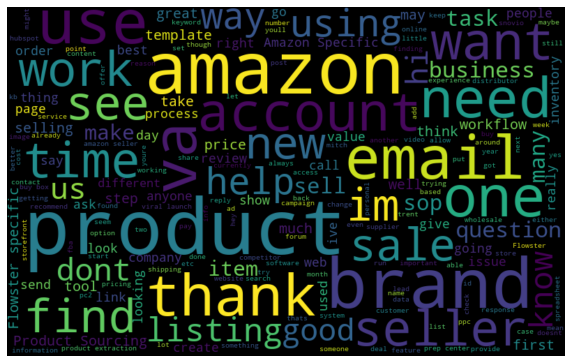

In [16]:
all_words = ' '.join([text for text in df['Tokens']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

#### Understanding the tokens used in each Category

In [17]:
df_categories = df[['Category', 'Tokens']].groupby(by='Category').agg(lambda x: ' '.join(x))

df_categories['Bag of Words'] = ''
columns = ['Tokens']

for index, row in df_categories.iterrows():
    words = ''
    for c in columns:
        words += ''.join(row[c]) + ' '
    row['Bag of Words'] = words

df_categories['Bag of Words'] = df_categories['Bag of Words'].str.strip().str.replace('  ', ' ')
df_categories

,Tokens,Bag of Words
Category,,
Amazon Specific,Amazon Specific questions using amazon marketp...,Amazon Specific questions using amazon marketp...
Financial Management,Financial Management questions financial manag...,Financial Management questions financial manag...
Flowster-specific,Flowster-specific discussion flowster forums o...,Flowster-specific discussion flowster forums o...
Fulfillment,Fulfillment questions fulfillment category use...,Fulfillment questions fulfillment category use...
Human Resources,Human Resources questions human resources cate...,Human Resources questions human resources cate...
Management,Management questions management category use p...,Management questions management category use p...
Misc Topics,Misc Topics questions things dont fall categor...,Misc Topics questions things dont fall categor...
Product Sourcing,Product Sourcing questions sourcing products c...,Product Sourcing questions sourcing products c...
Software & Tools,Software & Tools questions software tools cate...,Software & Tools questions software tools cate...


In [18]:
df_categories['Bag of Words'][1]

'Financial Management questions financial management category use please sure select appropriate subcategory questions Financial Management speaking cashback cardsi hear people often mention chase inksaphirecapital one sparkamex platinumcenturionetc business purpose uber visa alliant visa personal use checked cardsbut read small print available us citizens continental ushawaiipuerto rico anyone know cashback cardthat used usa non us citizen thats good question anyone luckni would definitely google search one might better cashback card bank home country dont mention reach currently credit cards see helpni know years ago moved us canada citizenship countries credit history issue able get card professional association member nspe citizen im sure helps nnn lizdnni would definitely google search one might better cashback card bank home country dont mention reach currently credit cards see helpnnnwhere come system cashback yet making baby stepsit first introduced last year last year virtuall

In [20]:
from sklearn.feature_extraction.text import CountVectorizer 
cv=CountVectorizer(analyzer='word')
data = cv.fit_transform(df_categories['Bag of Words'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index = df_categories.index
df_dtm

,015,025,050,055pound,060719jpg11251323,10,100,1000,1000mo,1000s,...,zaped,zapier,zapiernnnnnnnif,zapiernnnnzapier,zaps,zentail,zero,zonmaster,zoom,zoominfocom
Category,,,,,,,,,,,,,,,,,,,,,
Amazon Specific,2,1,2,0,0,3,4,0,0,0,...,0,0,0,0,0,0,0,2,0,0
Financial Management,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Flowster-specific,0,0,0,0,0,14,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
Fulfillment,0,0,0,1,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Human Resources,0,0,0,0,0,1,2,2,0,2,...,0,0,0,0,0,0,0,0,0,1
Management,0,0,0,0,0,4,1,0,0,0,...,0,5,1,1,4,0,2,0,0,0
Misc Topics,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Product Sourcing,0,0,0,0,1,10,7,0,0,0,...,0,0,0,0,0,0,0,0,6,0
Software & Tools,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,1,0


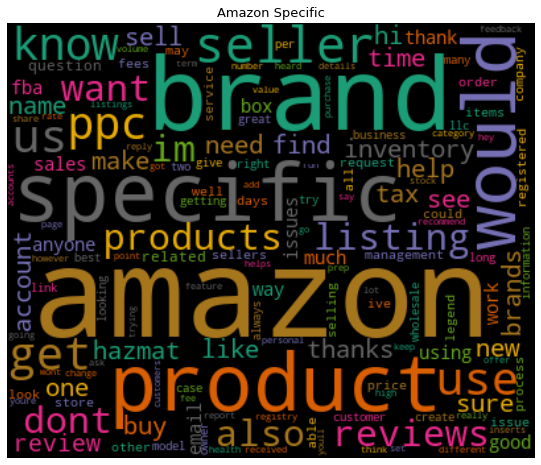

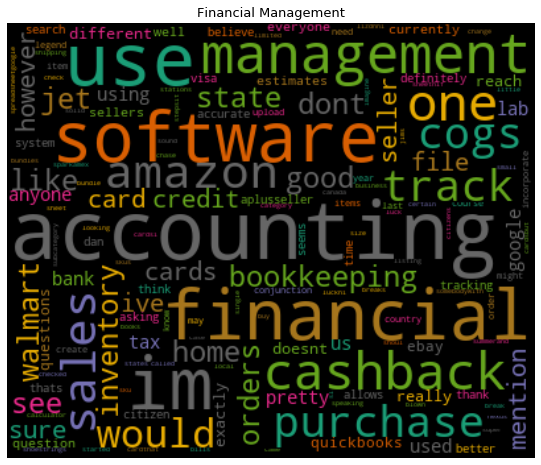

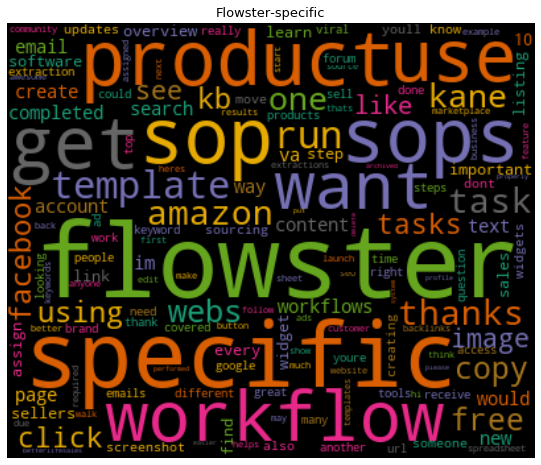

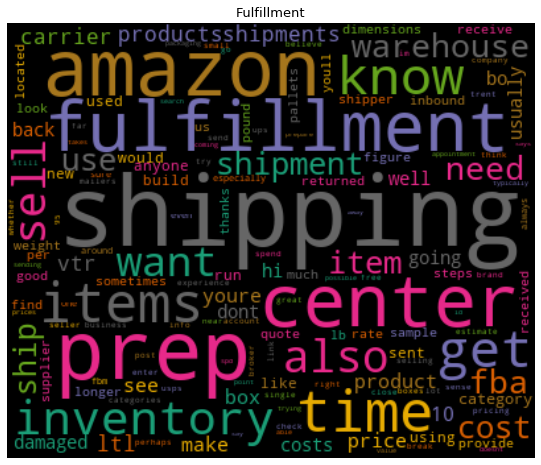

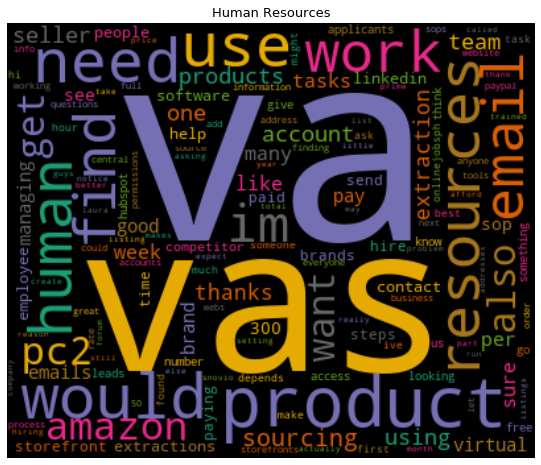

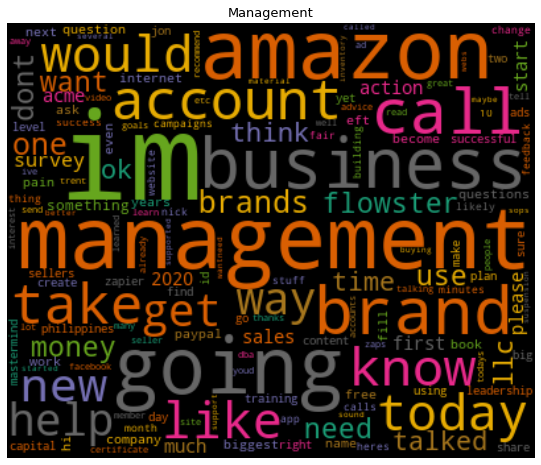

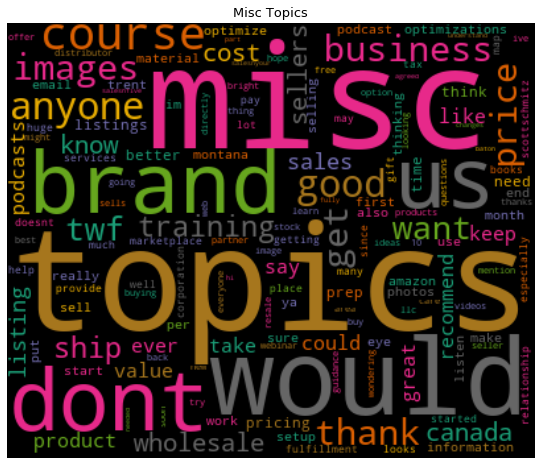

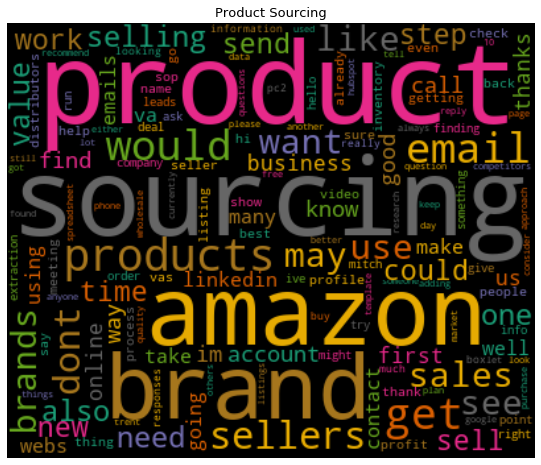

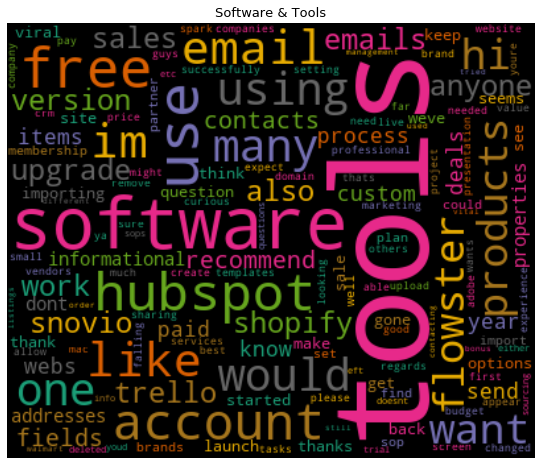

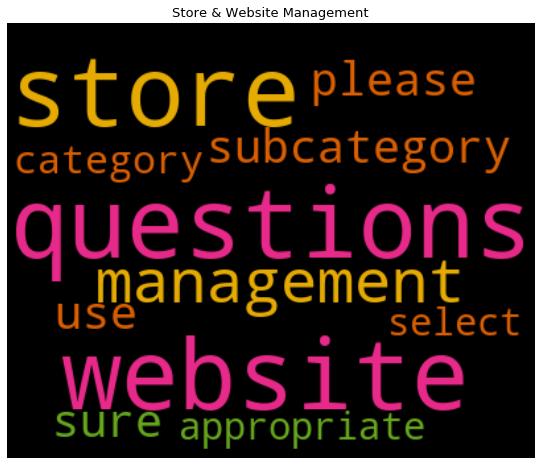

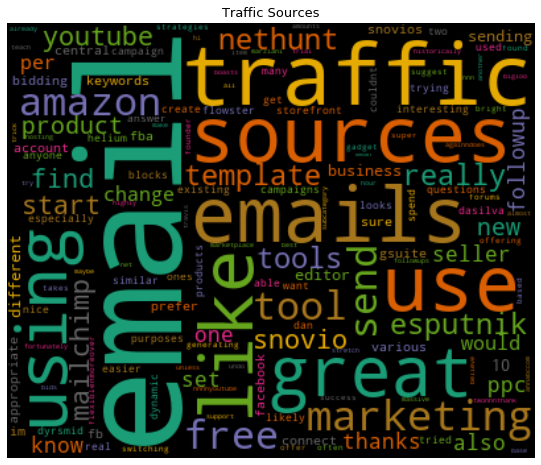

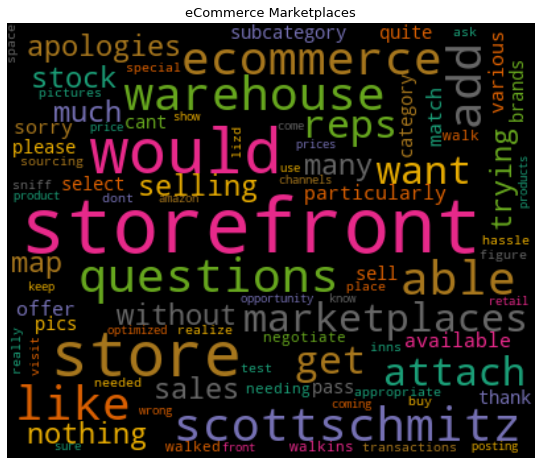

In [21]:
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for each product
for index,categ in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[categ].sort_values(ascending=False),categ)

This gave us an abstract idea of what words are being widely used in which category and some intuition about the relation between two or more words.

## Analysing Pre-Processed Data

To analyse a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques namely Bag of Words, TF-IDF, and Word Embeddings.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

### Bag of Words Features

Consider a Corpus C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. The N tokens (words) will form a dictionary and the size of the bag-of-words matrix M will be given by D X N. Each row in the matrix M contains the frequency of tokens in document D(i).

Let us understand this using a simple example.

D1: He is a lazy boy. She is also lazy.

D2: Smith is a lazy person.

The dictionary created would be a list of unique tokens in the corpus = [‘He’,’She’,’lazy’,’boy’,’Smith’,’person’]

Here, D=2, N=6

The matrix M of size 2 X 6 will be represented as –imgur

|    | He | She | lazy | boy | Smith | person |
|----|----|-----|------|------|-------|--------|
| D1 | 1  | 1   | 2    | 1    | 0     | 0      |
| D2 | 0  | 0   | 1    | 0    | 1     | 1      |

Now the columns in the above matrix can be used as features to build a classification model.

In [33]:
# Calculate the total number of tokens in all samples
num_tokens = 0
num_tokens += sum(df['Tokens'].apply(lambda x: len(x.split())))
num_tokens

26523

In [42]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=25000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['Tokens'])
print(bow[0])

  (0, 1318)	1
  (0, 1630)	2
  (0, 1366)	2
  (0, 1321)	1
  (0, 285)	1
  (0, 1848)	1
  (0, 1703)	1
  (0, 1535)	1
  (0, 126)	1
  (0, 1683)	1


In [240]:
bow.shape

(260, 1977)

### TF-IDF Features

This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

TF-IDF works by penalising the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

Let’s have a look at the important terms related to TF-IDF:

###### TF = (Number of times term t appears in a document)/(Number of terms in the document)

###### IDF = log(D/n), where, D is the number of documents and n is the number of documents a term t has appeared in.

###### TF-IDF = TF * IDF

In [44]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=25000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['Tokens'])
print(tfidf[0])

  (0, 1683)	0.34447665198339084
  (0, 126)	0.3201851962124115
  (0, 1535)	0.30567441046970567
  (0, 1703)	0.20580933060013162
  (0, 1848)	0.16294878059171267
  (0, 285)	0.31023976799425834
  (0, 1321)	0.19201840041524493
  (0, 1366)	0.5458641060544509
  (0, 1630)	0.40106040518205077
  (0, 1318)	0.15663267495562536


In [45]:
tfidf.shape

(260, 1977)

### Word2Vec Features

Word embeddings are the modern way of representing words as vectors. The objective of word embeddings is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus.

They are able to achieve tasks like **King -man +woman = Queen**

The advantages of using word embeddings over BOW or TF-IDF are:

1. Dimensionality reduction - significant reduction in the no. of features required to build a model.

2. It capture meanings of the words, semantic relationships and the different types of contexts they are used in.

#### Word2Vec Embeddings

Word2Vec is not a single algorithm but a combination of two techniques – **CBOW (Continuous bag of words)** and **Skip-gram model**. Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). Both of these techniques learn weights which act as word vector representations.

CBOW tends to predict the probability of a word given a context. A context may be a single adjacent word or a group of surrounding words. The Skip-gram model works in the reverse manner, it tries to predict the context for a given word.

Below is a diagrammatic representation of a 1-word context window Word2Vec model.

<img src="https://i.imgur.com/f77V0dH.png"
     alt="Markdown Monster icon"
     style="float: middle; margin-middle: 10px;" />

There are three laters: 
- an input layer
- a hidden layer
- an output layer

The input layer and the output, both are one-hot encoded of size [1 X V], where V is the size of the vocabulary (no. of unique words in the corpus). The output layer is a softmax layer which is used to sum the probabilities obtained in the output layer to 1. The weights learned by the model are then used as the word-vectors.

The Skip-gram model has the following advantages-

- It can capture two semantics for a single word. i.e it will have two vector representations of ‘apple’. One for the company Apple and the other for the fruit.

- Skip-gram with negative sub-sampling outperforms CBOW generally.

Here, we will train a Word2Vec model on our data to obtain vector representations for all the unique words present in our corpus. There is one more option of using pre-trained word vectors instead of training our own model. Some of the freely available pre-trained vectors are:

1. [Google News Word Vectors](https://code.google.com/archive/p/word2vec/)

2. [Freebase names](https://code.google.com/archive/p/word2vec/ )

3. [DBPedia vectors (wiki2vec)](https://github.com/idio/wiki2vec#prebuilt-models)

Let’s train a Word2Vec model on our own corpus first.

In [197]:
%%time

tokens = df['Tokens'].apply(lambda x: x.split())

model_w2v = gensim.models.Word2Vec(
            tokens,
            size=1977, # desired no. of features/independent variables
            window=2, # context window size
            min_count=1, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokens, total_examples= len(df['Tokens']), epochs=20)

Wall time: 23.1 s


(502350, 530460)

Let's check our model for certain words that appeared in the word-clouds. We will get the top 10 words which have a similar vector representation and hence a similar context to the word we specified. 

In [198]:
model_w2v.wv.most_similar(positive="amazon")

[('fba', 0.9417741298675537),
 ('hazmat', 0.9414352774620056),
 ('selling', 0.9391951560974121),
 ('items', 0.9221761226654053),
 ('ppc', 0.9015825986862183),
 ('products', 0.8947850465774536),
 ('central', 0.893470287322998),
 ('fbm', 0.892693042755127),
 ('top', 0.8921246528625488),
 ('competitive', 0.8868863582611084)]

In [199]:
model_w2v.wv.most_similar(positive="va")

[('trained', 0.8904993534088135),
 ('hiring', 0.8808367252349854),
 ('employee', 0.8770015835762024),
 ('start', 0.8769297003746033),
 ('tasks', 0.8759841322898865),
 ('hubspot', 0.8719602823257446),
 ('assign', 0.870569109916687),
 ('go', 0.864598274230957),
 ('suppliers', 0.8638529181480408),
 ('whole', 0.8629605770111084)]

In [50]:
model_w2v.wv.most_similar(positive="account")

[('registry', 0.9154020547866821),
 ('responsible', 0.8998266458511353),
 ('ads', 0.8948501348495483),
 ('mailchimp', 0.8936694860458374),
 ('keywords', 0.8927489519119263),
 ('whomever', 0.89129239320755),
 ('campaigns', 0.8886987566947937),
 ('search', 0.8869826793670654),
 ('ad', 0.8862078189849854),
 ('structure', 0.8843560218811035)]

In [51]:
model_w2v.wv.most_similar(positive="free")

[('version', 0.9225897789001465),
 ('tools', 0.907256007194519),
 ('required', 0.8998210430145264),
 ('snovio', 0.8990065455436707),
 ('team', 0.8875847458839417),
 ('downloaded', 0.8857139348983765),
 ('helium10', 0.8824682235717773),
 ('paid', 0.882436990737915),
 ('trello', 0.8797209858894348),
 ('versions', 0.8785680532455444)]

In [52]:
model_w2v.wv.most_similar(positive="know")

[('wont', 0.8795641660690308),
 ('much', 0.8545213937759399),
 ('let', 0.8539441823959351),
 ('answer', 0.8502456545829773),
 ('thought', 0.8484687805175781),
 ('look', 0.8453654646873474),
 ('experience', 0.8417460918426514),
 ('appreciate', 0.8385047912597656),
 ('good', 0.8384419083595276),
 ('better', 0.8365465998649597)]

In [53]:
model_w2v.wv.most_similar(positive="tools")

[('required', 0.9726786613464355),
 ('versions', 0.9501592516899109),
 ('downloaded', 0.9467087984085083),
 ('administration', 0.9426817297935486),
 ('revseller', 0.9426271915435791),
 ('allows', 0.9425015449523926),
 ('feel', 0.9415121674537659),
 ('jungle', 0.9412120580673218),
 ('gave', 0.9386638402938843),
 ('linked', 0.9380353689193726)]

In [55]:
model_w2v.wv.most_similar(positive="product")

[('sheet', 0.8848152160644531),
 ('extraction', 0.8754554986953735),
 ('spreadsheet', 0.8644602298736572),
 ('listing', 0.8393117189407349),
 ('sponsored', 0.8389298915863037),
 ('shown', 0.8346543908119202),
 ('google', 0.8160448670387268),
 ('new', 0.81110680103302),
 ('important', 0.8063341975212097),
 ('ads', 0.8056730031967163)]

In [57]:
print(model_w2v['amazon'])

[-0.00876042  0.06309903 -0.0109546  ... -0.09089895  0.04171591
 -0.08081061]


J:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


A keen observation tells us that most of the reported words appear to be related to the specified word, and some even appear in the same word-cloud that we made earlier. However, since the sample size is just 260, the accuracy (in similarity) reduces significantly as we get to the 10th reported word.

In [58]:
len(model_w2v['amazon'])

J:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


1977

#### Preparing Vectors for Comments

Since our original data contains Comments and not just a set of words, we'll have to figure out a way to use the word vectors from word2vec model to create vector representation for an entire comment. 

A simple solution is to take the mean of all word vectors present in the comment. The length of the resultant vector will be the same, i.e. 1977. We will repeat the same process for all the comments in our data and obtain their vectors. So we will have 1977 word2vec features for our data.

In [59]:
import numpy as np
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [69]:
wordvec_arrays = np.zeros((len(tokens), 1977)) 
for i in range(len(tokens)):
    wordvec_arrays[i,:] = word_vector(tokens[i], 1977)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

J:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


(260, 1977)

In [70]:
wordvec_df

,0,1,2,3,4,5,6,7,8,9,...,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976
0,-0.037777,0.017041,-0.052036,-0.007453,0.011701,-0.013399,0.062085,0.159243,0.039791,-0.037312,...,0.068369,0.117188,-0.092197,0.025585,-0.004195,0.080101,0.008840,-0.007592,0.087191,-0.044986
1,-0.014322,0.012843,-0.031660,-0.010767,0.055862,-0.001040,0.031320,0.102250,0.058704,-0.007239,...,0.052741,0.093857,-0.056067,0.015529,-0.000911,0.041742,0.043061,-0.038161,0.044130,-0.007369
2,-0.027913,0.030738,-0.029294,-0.009937,0.045869,-0.001755,0.002010,0.076396,0.036948,-0.028727,...,0.072731,0.082408,-0.039596,0.021174,-0.003278,0.038947,0.039136,-0.059144,0.033381,-0.035559
3,-0.018505,0.010974,-0.040778,-0.010102,0.047852,0.005753,0.025160,0.084604,0.050567,-0.015311,...,0.057893,0.094256,-0.050935,0.018415,-0.005748,0.046086,0.042046,-0.038094,0.033950,-0.009219
4,-0.018130,0.018515,-0.040934,-0.019570,0.032829,-0.000909,0.020059,0.104961,0.042810,-0.017808,...,0.075368,0.097942,-0.068149,0.025605,-0.010809,0.057656,0.024333,-0.047058,0.052095,-0.019694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,-0.017241,0.021147,-0.039313,-0.002625,0.034304,-0.002069,0.010370,0.074637,0.034195,-0.026497,...,0.071843,0.076931,-0.036515,0.019411,-0.011652,0.044932,0.030914,-0.047511,0.033030,-0.031002
256,-0.012157,0.012816,-0.039377,0.003250,0.031622,-0.008166,0.023724,0.089779,0.045045,-0.025693,...,0.062647,0.079505,-0.045443,0.015014,-0.016342,0.053077,0.032247,-0.033403,0.039035,-0.025255
257,-0.039462,0.023919,-0.042846,-0.007538,0.025860,-0.005083,0.035744,0.115158,0.032887,-0.042568,...,0.066794,0.094382,-0.059954,0.023098,0.001702,0.053304,0.020053,-0.013790,0.057473,-0.045791
258,-0.023411,0.029248,-0.032597,-0.010833,0.052865,0.010373,-0.002631,0.064455,0.033360,-0.026805,...,0.070546,0.084250,-0.029668,0.019678,0.000394,0.033382,0.039086,-0.057114,0.023199,-0.027332


### Doc2Vec Embedding

Doc2Vec model is an unsupervised algorithm to generate vectors for sentence/paragraphs/documents. This approach is an extension of the word2vec. The major difference between the two is that doc2vec provides an additional context which is unique for every document in the corpus. This additional context is nothing but another feature vector for the whole document. This document vector is trained along with the word vectors.

<img src="https://i.imgur.com/RBlg4xJ.png"
     alt="Markdown Monster icon"
     style="float: middle; margin-middle: 10px;" />

In [71]:
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import LabeledSentence

J:\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


To implement doc2vec, we have to labelise or tag each tokenised comment with unique IDs. We can do so by using Gensim’s LabeledSentence() function.

In [72]:
def add_label(cmnt):
    output = []
    for i, s in zip(cmnt.index, cmnt):
        output.append(LabeledSentence(s, ["comment_" + str(i)]))
    return output

labeled_comments = add_label(tokens) # label all the tweets

J:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  after removing the cwd from sys.path.


In [75]:
labeled_comments[:3]

[LabeledSentence(words=['Product', 'Sourcing', 'questions', 'sourcing', 'products', 'category', 'use', 'please', 'sure', 'select', 'appropriate', 'subcategory', 'questions'], tags=['comment_0']),
 LabeledSentence(words=['Product', 'Sourcing', 'hi', 'new', 'forum', 'going', 'product', 'sourcing', 'professionals', 'sops', 'question', 'product', 'extraction', 'workflow', 'process', 'using', 'pc2', 'downloaded', 'free', 'version', 'doesnt', 'button', 'says', 'amazon', 'browsersearches', 'need', 'purchase', 'full', 'pc2', 'package', 'get', 'feature', 'thanks', 'help', 'advance', 'yes', 'need', 'paid', 'version', 'options', 'extraction', 'tools', 'include', 'pc2', 'tactical', 'arbitrage', 'helium10', 'require', 'paid', 'version', 'run', 'scale'], tags=['comment_1']),
 LabeledSentence(words=['Product', 'Sourcing', 'Purchasing', 'working', 'amazon', 'seller', 'last', '6', 'years', 'want', 'tips', 'selling', 'growing', 'business', 'fastly', 'like', 'grow', 'business', 'tips', 'please', 'read', 

Now, let's train a doc2vec model.

In [192]:
model = Doc2Vec(alpha=0.01, min_alpha=0.025)
model.build_vocab(labeled_comments)
for epoch in range(10):
    model.train(labeled_comments, total_examples= len(df['Tokens']), epochs = model.epochs)
    model.alpha -= 0.002
    model.min_alpha = model.alpha

In [202]:
model.most_similar(positive=["software", "management", "product"], topn=10)

J:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('important', 0.9999721050262451),
 ('use', 0.9999664425849915),
 ('pc2', 0.9999663233757019),
 ('would', 0.9999650120735168),
 ('using', 0.9999642372131348),
 ('two', 0.9999626278877258),
 ('page', 0.9999620914459229),
 ('little', 0.9999605417251587),
 ('etc', 0.9999603629112244),
 ('show', 0.9999602437019348)]

In [194]:
model.wv.most_similar(["software", "management", "product"])

[('important', 0.9999721050262451),
 ('use', 0.9999664425849915),
 ('pc2', 0.9999663233757019),
 ('would', 0.9999650120735168),
 ('using', 0.9999642372131348),
 ('two', 0.9999626278877258),
 ('page', 0.9999620914459229),
 ('little', 0.9999605417251587),
 ('etc', 0.9999603629112244),
 ('show', 0.9999602437019348)]

In [217]:
model.most_similar(positive=["select", "subcategory"], topn=10)

J:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('appropriate', 0.9999162554740906),
 ('please', 0.9999144077301025),
 ('questions', 0.9998821020126343),
 ('sure', 0.9998590350151062),
 ('management', 0.9998378157615662),
 ('make', 0.9998018741607666),
 ('use', 0.9998006224632263),
 ('im', 0.9998002052307129),
 ('post', 0.9997962117195129),
 ('follow', 0.9997944235801697)]

In [218]:
model.most_similar(positive=["please", "sure", "select"], topn=10)

J:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('questions', 0.9999384880065918),
 ('make', 0.9999338984489441),
 ('appropriate', 0.9999325275421143),
 ('post', 0.9999280571937561),
 ('thanks', 0.9999263286590576),
 ('customer', 0.9999262094497681),
 ('use', 0.9999246597290039),
 ('im', 0.9999237656593323),
 ('deal', 0.9999207258224487),
 ('store', 0.9999200701713562)]

In [222]:
model.most_similar(positive=["business", "grow"], topn=10)

J:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('sales', 0.9999467134475708),
 ('well', 0.9999439120292664),
 ('say', 0.9999438524246216),
 ('may', 0.9999437928199768),
 ('state', 0.9999433159828186),
 ('got', 0.9999432563781738),
 ('idea', 0.9999431371688843),
 ('right', 0.9999428987503052),
 ('however', 0.9999424815177917),
 ('believe', 0.9999414682388306)]

In [225]:
model.most_similar(positive=["improve", "amazon"], topn=10)

J:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('may', 0.9999673366546631),
 ('inventory', 0.9999595284461975),
 ('idea', 0.9999592900276184),
 ('products', 0.9999582767486572),
 ('worth', 0.9999580383300781),
 ('high', 0.9999579191207886),
 ('change', 0.9999573230743408),
 ('believe', 0.9999567866325378),
 ('sales', 0.9999560117721558),
 ('sellers', 0.9999547600746155)]

In [226]:
model.most_similar(positive=["product", "management"], topn=10)

J:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('important', 0.9999575614929199),
 ('pc2', 0.9999520778656006),
 ('two', 0.999951183795929),
 ('show', 0.9999498724937439),
 ('little', 0.9999489784240723),
 ('would', 0.9999489188194275),
 ('due', 0.9999469518661499),
 ('check', 0.9999463558197021),
 ('data', 0.9999459981918335),
 ('believe', 0.9999457597732544)]

In [227]:
model.most_similar(positive=["amazon", "prime"], topn=10)

J:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('brand', 0.9999408721923828),
 ('wholesale', 0.9999394416809082),
 ('top', 0.9999393224716187),
 ('article', 0.9999392628669739),
 ('selling', 0.999937891960144),
 ('good', 0.9999373555183411),
 ('listings', 0.9999369978904724),
 ('new', 0.9999369382858276),
 ('seems', 0.9999359846115112),
 ('find', 0.9999359846115112)]

In [235]:
model.most_similar(positive=['product', 'sourcing', 'professionals', 'sops', 'question', 'product', 'extraction', 'workflow', 'process', 'using', 'pc2'], topn=10)

J:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('important', 0.999963104724884),
 ('leads', 0.999962568283081),
 ('2', 0.9999620914459229),
 ('google', 0.9999615550041199),
 ('use', 0.9999613761901855),
 ('data', 0.9999562501907349),
 ('hubspot', 0.9999555349349976),
 ('show', 0.9999549984931946),
 ('competitor', 0.9999546408653259),
 ('first', 0.9999529719352722)]

<p style="color:blue">Interesting analysis and results, thank you I enjoyed going through the notebook.
One thing that would have been interesting is you explaining your intake from the visualizations you did in the first part of the notebook.</p>